You have done a great job studying the dataset library and now we have to learn how to use real models.

Today we will learn how to:
* use real models
* create configurate dict with params to real models
* draw a distribution of weights.

Using ResNet as an example.

We will use two different variations of the ResNet model.

__First network__ is ResNet with simple blocks that look like this:

<img src='./pictures/simple_block.png'>

Two advantages are:
* Thanks to the 3x3 convolutions, the number of parameters in the network does not increase significantly.
* Skipconnections allow us to increase the depth on the network without the vanishing gradients problem.

_total weights:_ __617472__

__Second model__ - Resnet with bottlenecks blocks, which look like this:

<img src='./pictures/bottle_block.png'>

Two convolutional layers 1x1 help to reduce the number of parameters by almost 3 times.

_total weights:_ __211712__

If what to лnow about ResNet more read: 
* [paper](https://arxiv.org/abs/1512.03385)
* [inplementation](https://github.com/analysiscenter/dataset/blob/master/dataset/models/tf/resnet.py)

In [1]:
import sys
import time

import numpy as np
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from tqdm import tqdm_notebook as tqn

sys.path.append('..')
import utils
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet50

We will use the MNIST dataset, because it is small and easily interpreted.

In [2]:
dset = MNIST()

ExtractingExtractingExtractingExtracting    /tmp/train-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz/tmp/t10k-labels-idx1-ubyte.gz





Real architectures, too, need to be configured, as are the conventional models that we have previously considered.

In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

In the __config__ we define all the parameters for our model. Such as __num_blocks__, or __filters__. About ResNet params read [here](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html).

Also you can use ready-made implementations. For example [ResNet18](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html#dataset.models.tf.resnet.ResNet18)

About other models you can read [here](https://analysiscenter.github.io/dataset/api/dataset.models.html).

In [4]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
                 'body/block/bottleneck': False}

Bottlenet_config = {**ResNet_config}
Bottlenet_config['body/block/bottleneck'] = True

As always don't forget about feed dict

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

Based on our config to ResNet model, we will create the pipelines and train them.

In [6]:
res_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet50,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resloss', init_on_each_run=list)
           .import_model('resnet', res_tr_ppl)
           .predict_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('resloss'), mode='a'))

Based on another config, we will train ResNet model with bottleneck blocks.

In [7]:
bott_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet50,
                      'bottle',
                      config=Bottlenet_config)
           .train_model('bottle',
                        feed_dict=placehold_dict))
bott_test_ppl = (dset.test
           .p
           .init_variable('bottloss', init_on_each_run=list)
           .import_model('bottle', bott_tr_ppl)
           .predict_model('bottle',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('bottloss'), mode='a'))

Train the model with the method already known to us - __next_batch__.

In [8]:
resnet_time = 0
bottle_time = 0
for i in tqn(range(300)):
    t = time.time()
    res_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    resnet_time += time.time() - t
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)

    t = time.time()
    bott_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bottle_time += time.time() - t
    bott_test_ppl.next_batch(400, n_epochs=None, shuffle=True)

After training compare loss-values of both models.

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


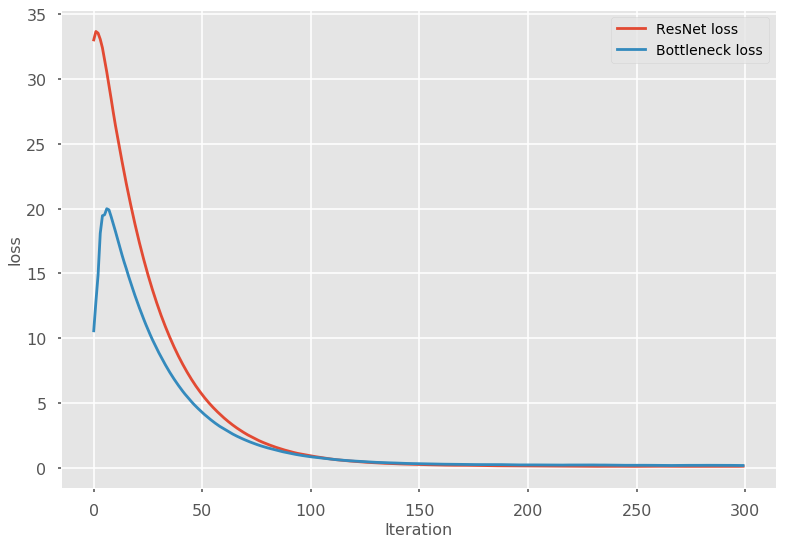

In [9]:
ResNet_loss = res_test_ppl.get_variable('resloss')
Bottle_loss = bott_test_ppl.get_variable('bottloss')
utils.draw(ResNet_loss, 'ResNet', Bottle_loss, 'Bottleneck')#, bound=[450, 500, 0.1, 0.2])

Network with bottleneck architectures has almost half the size of parameters, but training not worse than network with simple model. And bottleneck model train faster, than simple model.

After training you can say, that they accuracy is same, сonsequently there are no difference between networks.
But before summarize it, let's look on the distributions to all weights of two models and after that will be summarize our resuilts.



Load graph out of models and get all weights

In [10]:
bottle_sess = bott_tr_ppl.get_model_by_name("bottle").session
bottle_graph = bottle_sess.graph
bottle_names, bottle_weights, bottle_bias = utils.get_weights(bottle_sess)

In [11]:
res_sess = res_tr_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph
res_names, res_weights, res_bias = utils.get_weights(res_sess)

Let's count the numbers of parameters on each layer.

In [12]:
bottle_params = np.array([np.array(i.shape).prod() for i in bottle_weights])
res_params = np.array([np.array(i.shape).prod() for i in res_weights])

Draw the distribution of weights of convolutional layers from Bottleneck ResNet model. All function you can see in [utils](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/utils.py).

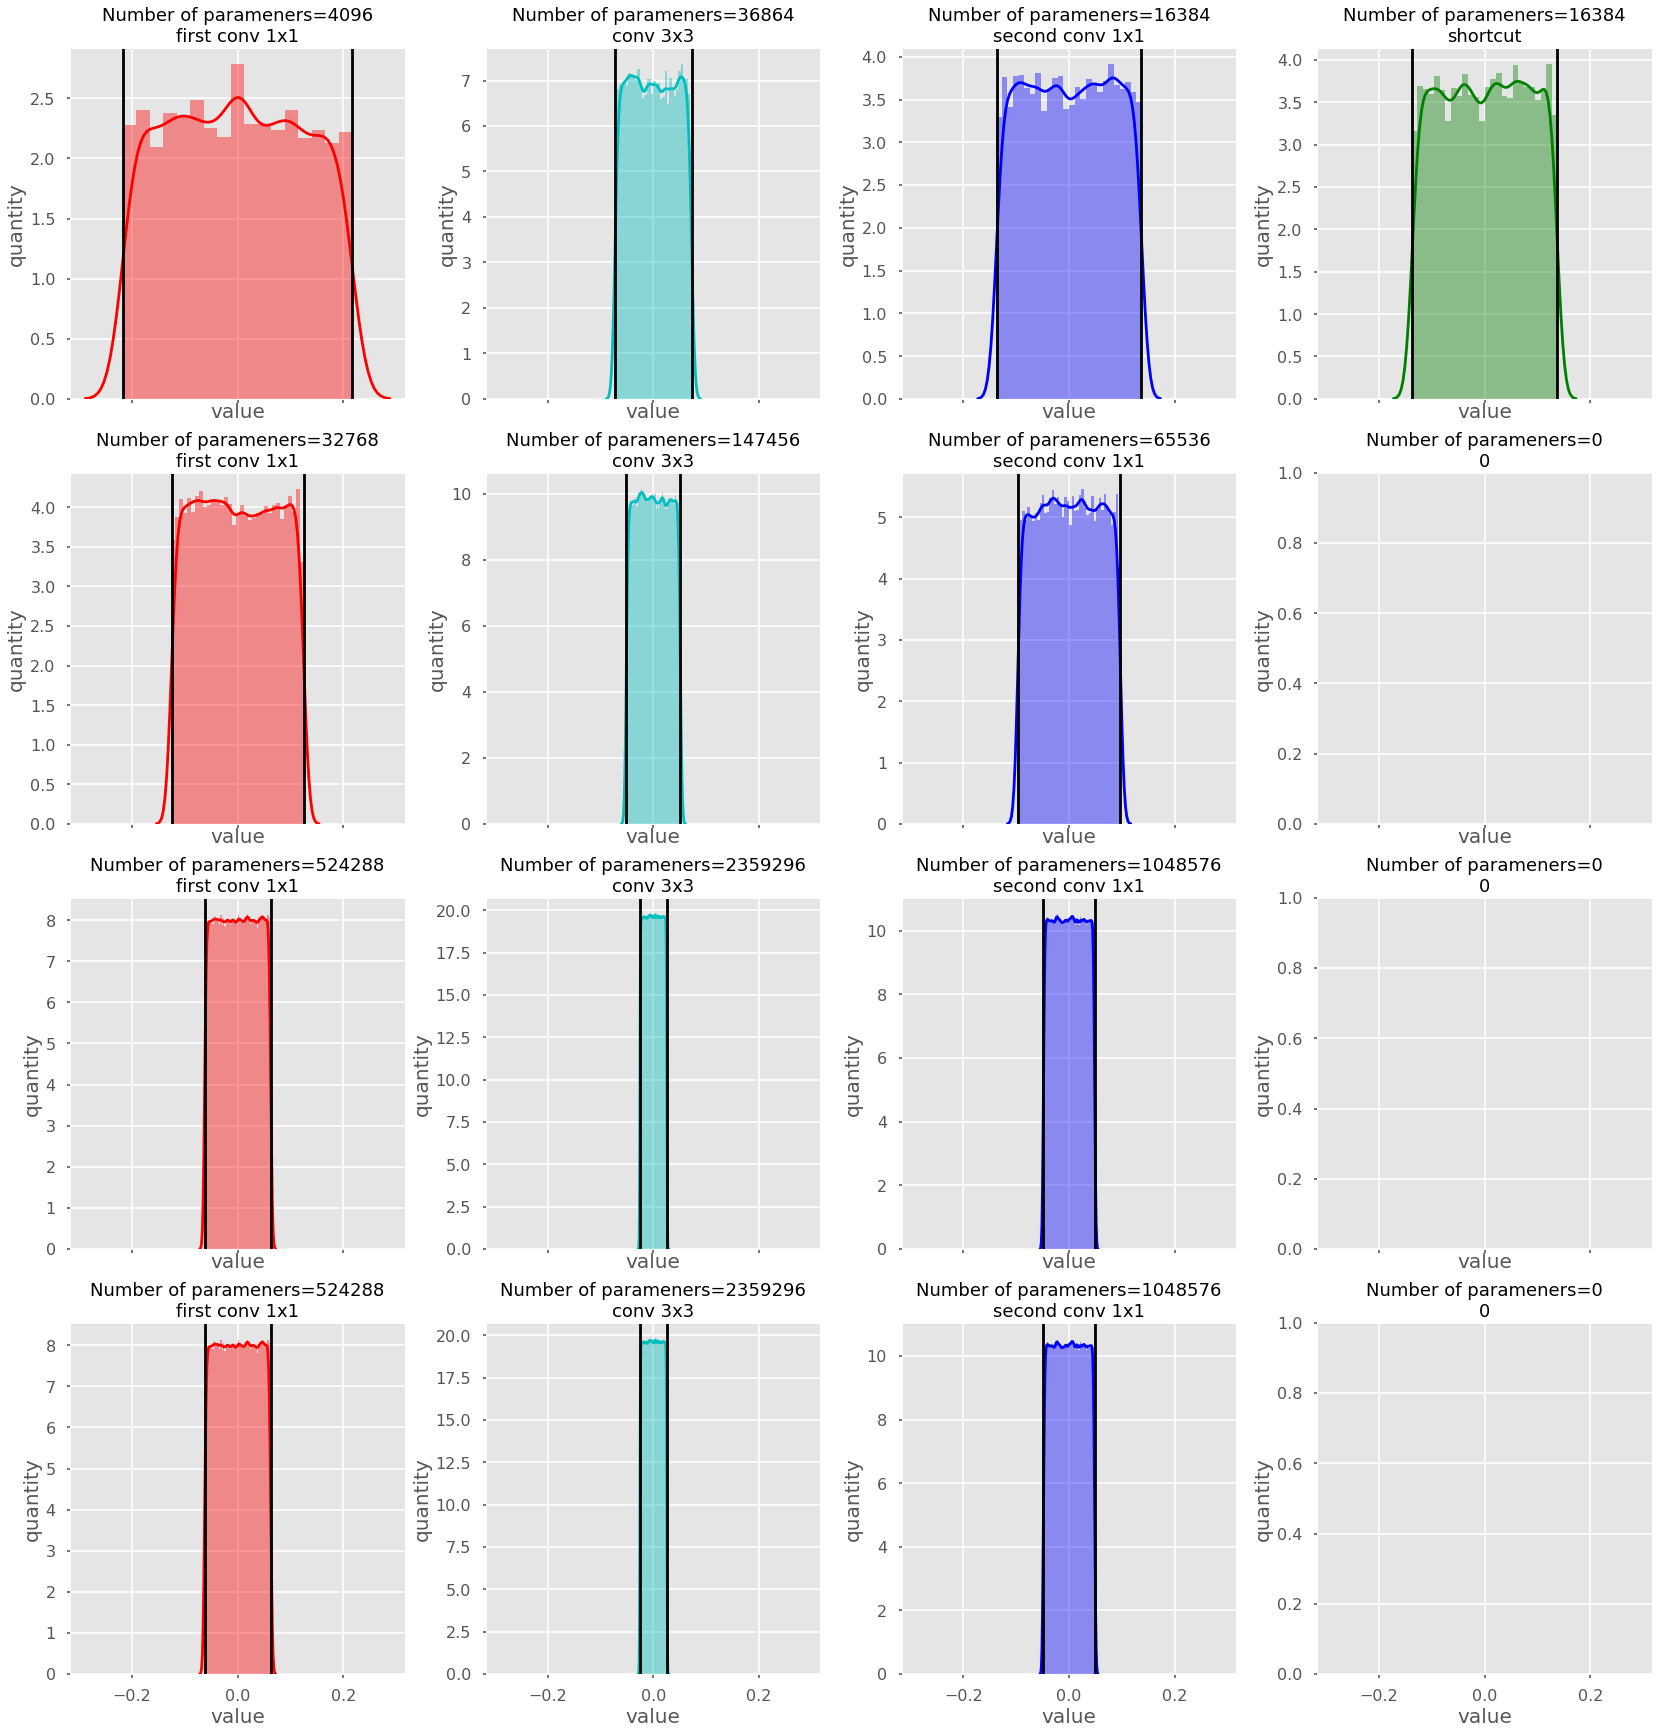

In [13]:
utils.plot_weights(bottle_names, bottle_weights, bottle_params, ['r', 'c', 'b', 'g'], [4, 4], [0, 3, 13, 13])

It's not difficult to notice, that distribution of 1x1 convolutions have a large variance, than convolution 3x3. Therefore, they exert a stronger influence on output.

 __Black lines show the initial distribution of weights__

______

It's time to draw distribution of ResNet model __without__ bottleneck.

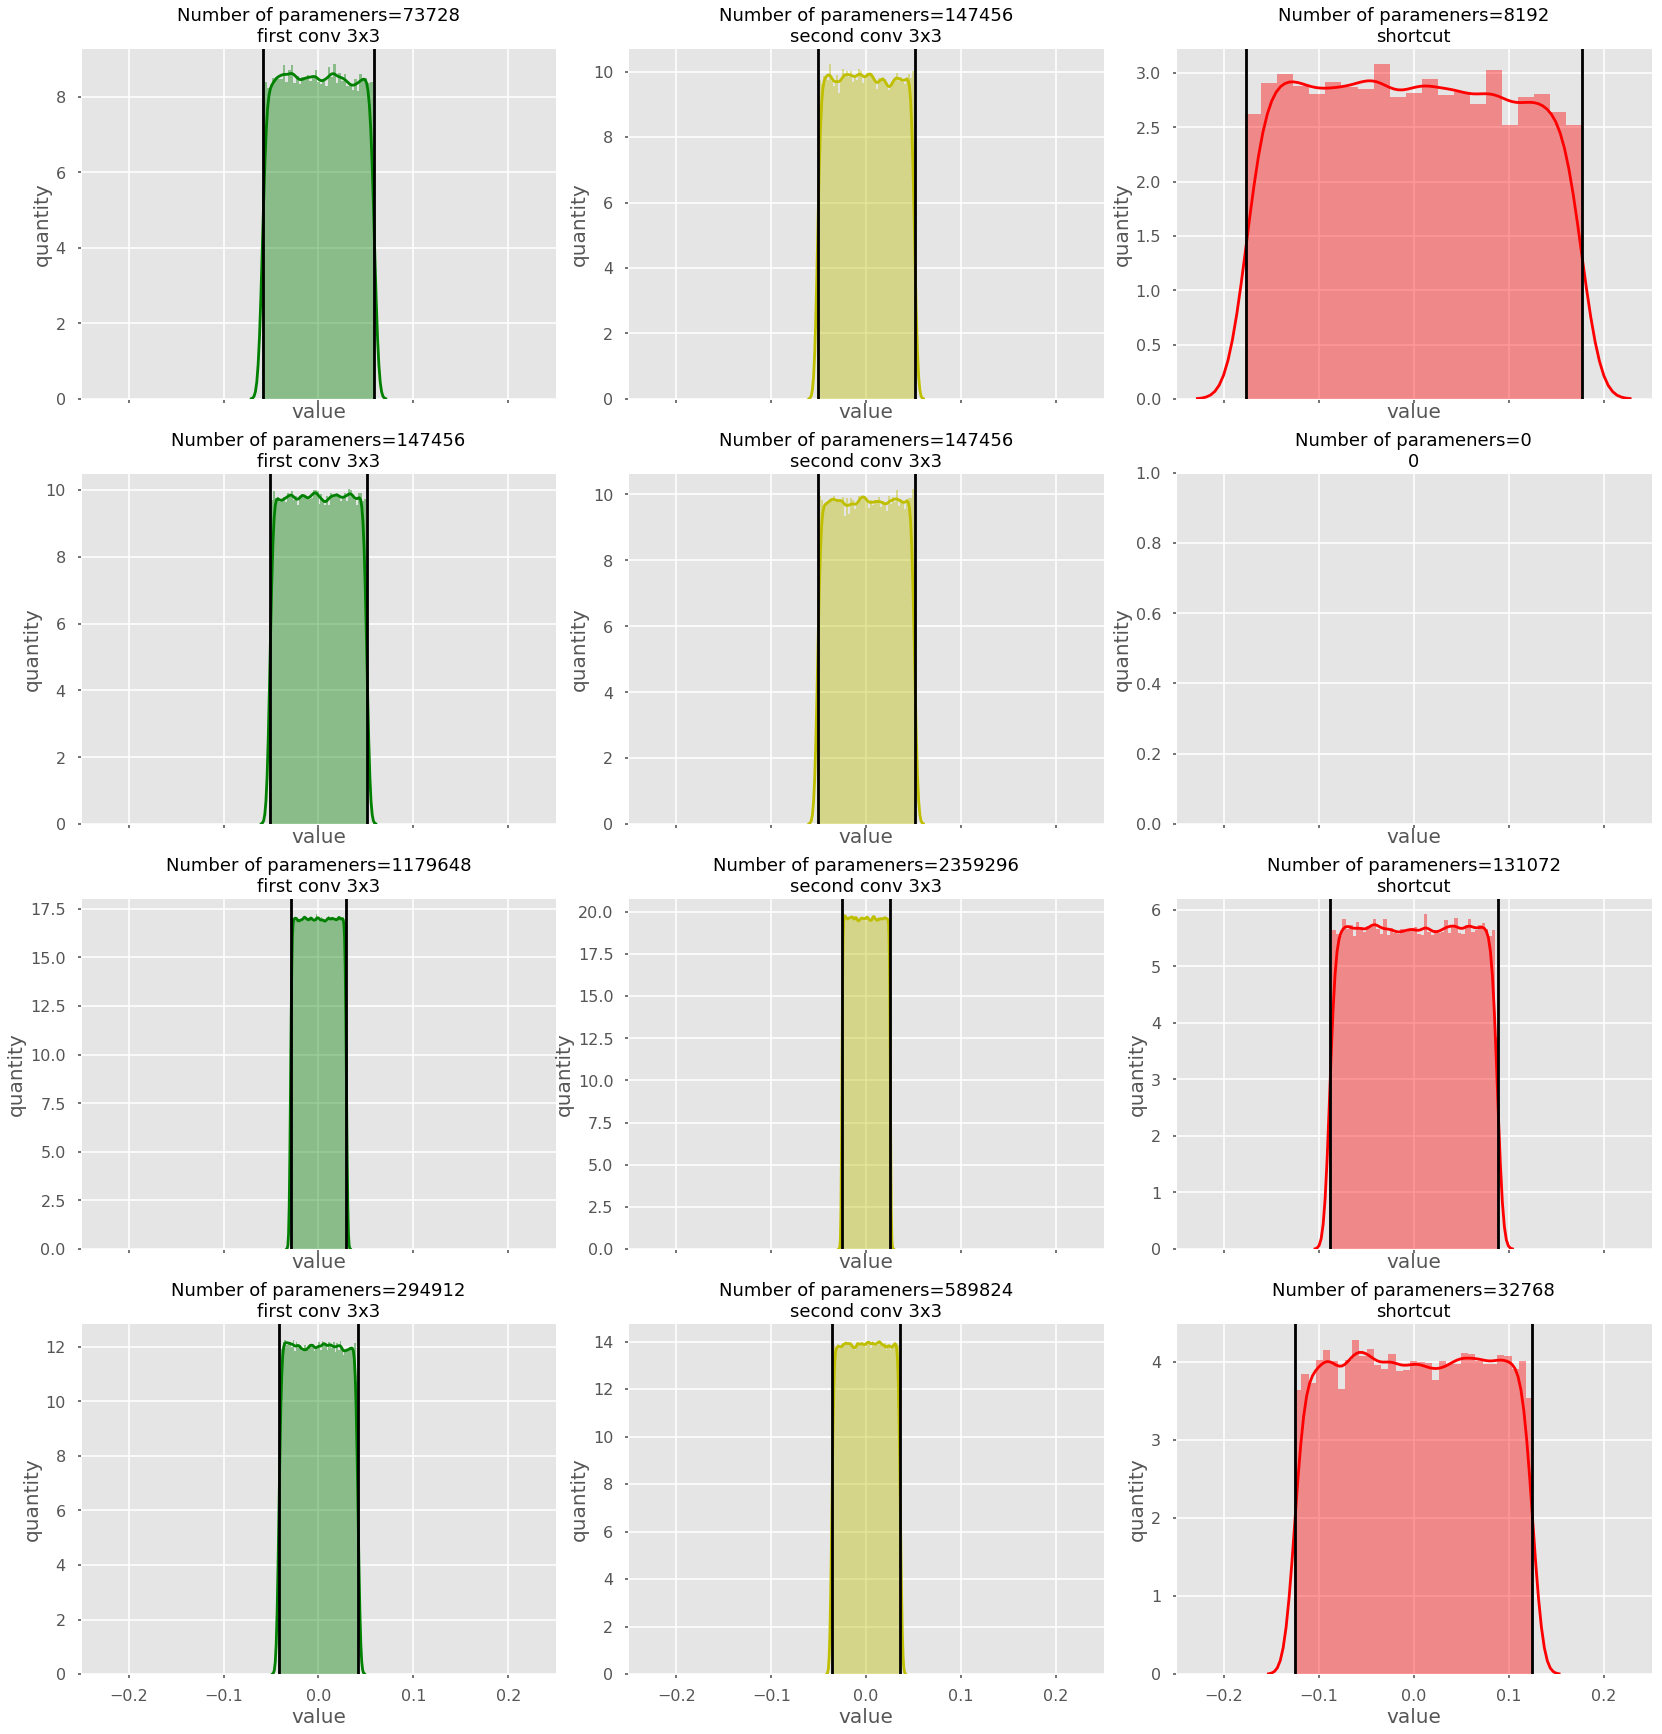

In [15]:
utils.plot_weights(res_names, res_weights, res_params, ['g', 'y', 'r'], [4, 3], [3, 4, 13, 7], bottleneck=False)

looking at the graphs you can see, that distribution of first convolution layers almost did not change, it happend because skipconnection allows change the weights of second convolution layer more than first. Hence, greater in comparison with the first distribution of second layer.

____

Now, let's compare the distribution of second layer of simple ResNet architecture and ResNet with bottlenecks blocks.

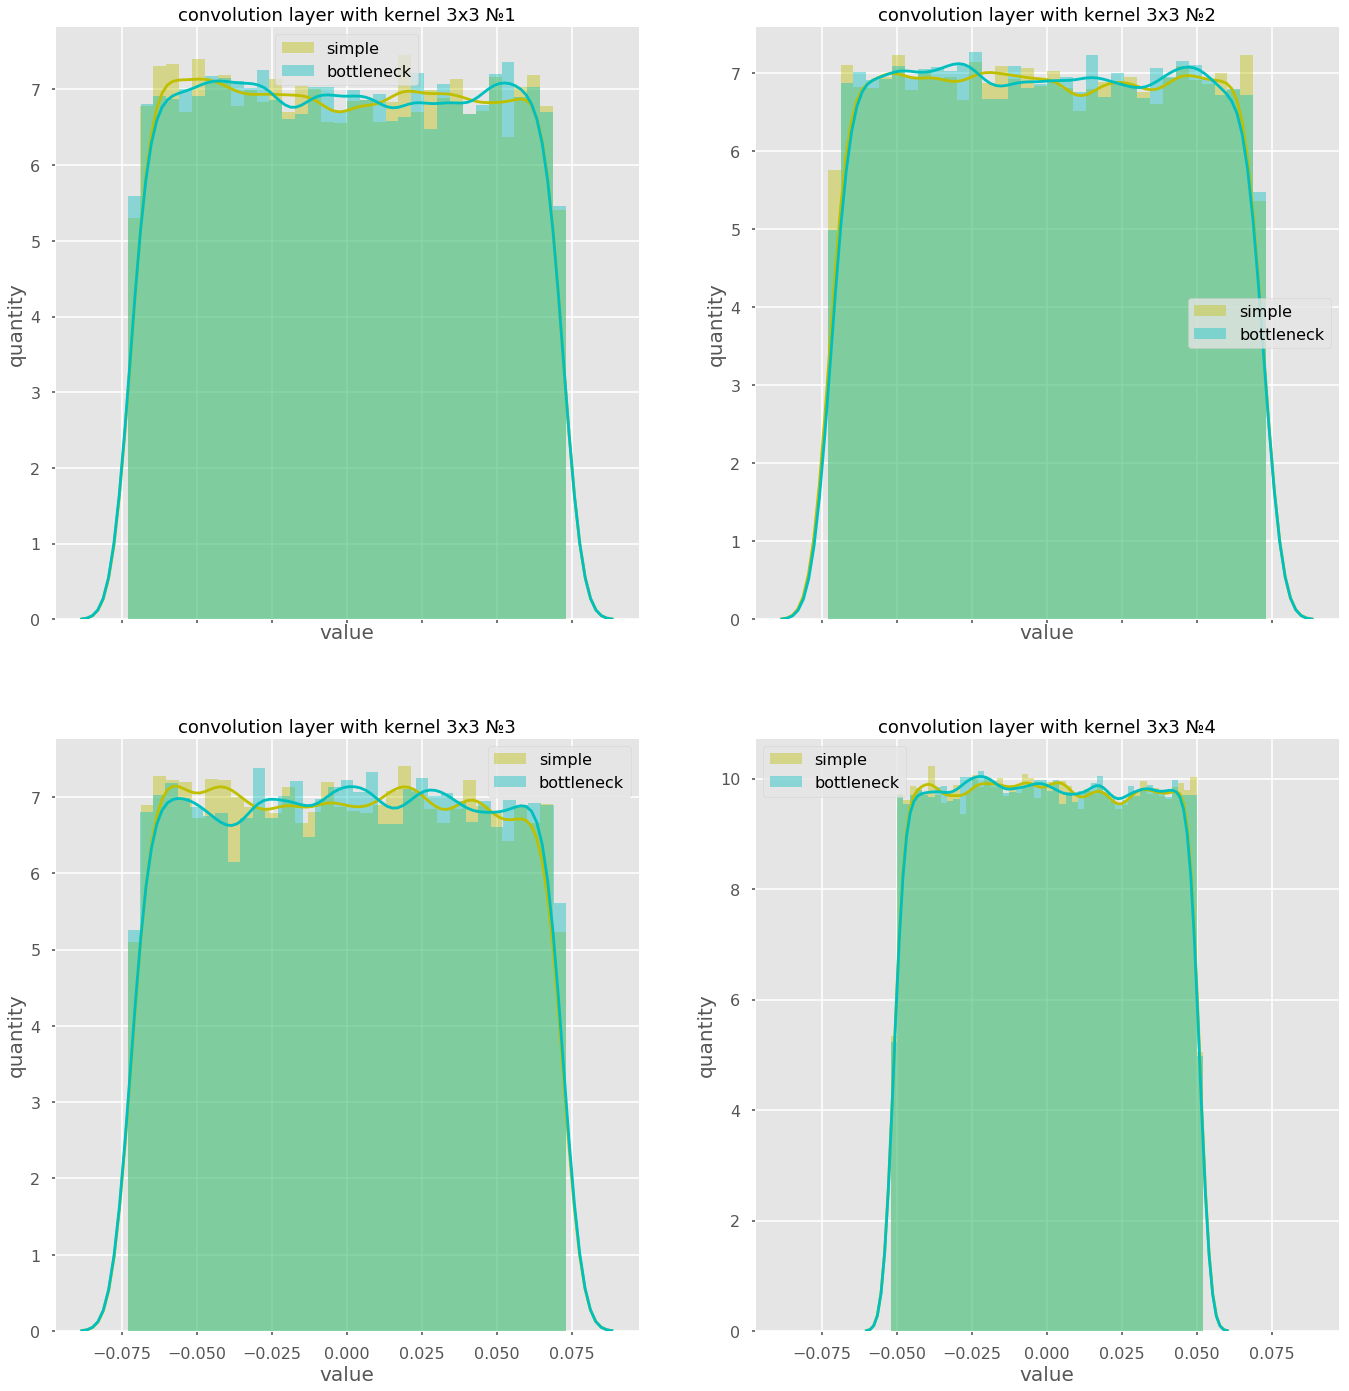

In [22]:
indices = [i for i in range(len(bottle_names)) if 'conv' in bottle_names[i][:8]]
_, ax = plt.subplots(2, 2, sharex='all', figsize=(23, 24))
ax = ax.reshape(-1)
num_plot = 0
for i,j in zip(np.where(res_names == 'layer-3')[0], np.where(bottle_names == 'layer-3')[0]):
    ax[num_plot].set_title('convolution layer with kernel 3x3 №{}'.format(num_plot + 1), fontsize=18)
    sns.distplot(res_weights[i].reshape(-1), ax=ax[num_plot], color='y', label='simple')
    sns.distplot(bottle_weights[j].reshape(-1), ax=ax[num_plot], color='c', label='bottleneck')
    ax[num_plot].legend()
    ax[num_plot].set_xlabel('value', fontsize=20)
    ax[num_plot].set_ylabel('quantity', fontsize=20)
    num_plot += 1
    if num_plot == ax.shape[0]:
        break
    

Graphs show, that distribution of ResNet with bottleneck block bigger than simple ResNet. It means that convolution 3x3 make smaller effect in train network, than convolutions 1x1. 

### And it's time to conclusions:
1. In this task we learn how use real models with dataset.
2. Now you can configurate you own model.
3. Convolutions with size 1x1 have have fewer parameters and allows train network faster, that with 3x3 convolutions, and 1x1 convolutions may have better quality.
4. Second layer after skipconnection in simple ResNet model have a bigger gradient than first layer and consequently will be train faster.
### And what next?
As you can see, use real model almost does not differ from simple usage of models. We offer you:
* Use ResNet model and train it on MNIST with 3-dimenstions.
* Configurate it with your own wish.
* And goal the score 0.99.

Congratulations you finished all training tasks!
But you can see our research notebooks if you don't see it:
* [zero_weights]()
* [Stochastic_ResNet]()
* [SE_ResNet]()